In [399]:
%matplotlib inline
import itertools
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import RMSprop

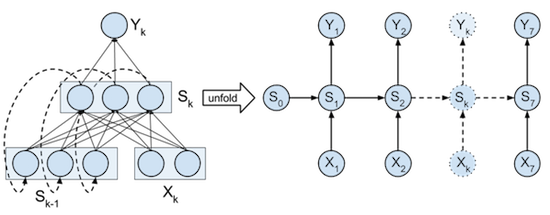

In [400]:
Image('SimpleRNN02_1.png')

In [341]:
# Create dataset
nb_train = 2000  # Number of training samples
# Addition of 2 n-bit numbers can result in a n+1 bit number
sequence_len = 10  # Length of the binary sequence

def create_dataset(nb_samples, sequence_len):
    """Create a dataset for binary addition and return as input, targets."""
    max_int = 2**(sequence_len-1) # Maximum integer that can be added
    format_str = '{:0' + str(sequence_len) + 'b}' # Transform integer in binary format
    nb_inputs = 2  # Add 2 binary numbers
    nb_outputs = 1  # Result is 1 binary number
    X = np.zeros((nb_samples, sequence_len, nb_inputs))  # Input samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))  # Target samples
    # Fill up the input and target matrix
    for i in range(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)
        # Fill current input and target row.
        # Note that binary numbers are added from right to left, but our RNN reads 
        #  from left to right, so reverse the sequence.
        X[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        X[i,:,1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        T[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1+nb2)]))
    return X, T

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print('X_train shape: {0}'.format(X_train.shape))
print('T_train shape: {0}'.format(T_train.shape))

X_train shape: (2000, 10, 2)
T_train shape: (2000, 10, 1)


In [342]:
# Show an example input and target
def printSample(x1, x2, t, y=None):
    """Print a sample in a more visual way."""
    x1 = ''.join([str(int(d)) for d in x1])
    x2 = ''.join([str(int(d)) for d in x2])
    t = ''.join([str(int(d[0])) for d in t])
    if not y is None:
        y = ''.join([str(int(d[0])) for d in y])
    print('x1:   {:s}   {:2d}'.format(x1, int(''.join(reversed(x1)), 2)))
    print('x2: + {:s}   {:2d} '.format(x2, int(''.join(reversed(x2)), 2)))
    print('      -------   --')
    print('t:  = {:s}   {:2d}'.format(t, int(''.join(reversed(t)), 2)))
    if not y is None:
        print('y:  = {:s}'.format(y))
    

In [393]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.20  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 100  # Size of the minibatches (number of samples)
# Create the network
nb_of_states = 3  # Number of states in the recurrent layer

class Adder(nn.Module):
    def __init__(self):
        super(Adder,self).__init__()
        self.rnn = nn.RNN(2,nb_of_states,1)
        self.lin = nn.Linear(nb_of_states,1)
    def forward(self,X0,h0):
        X,h=self.rnn(X0,h0)
        return self.lin(X),h
       
model = Adder()
criterion = nn.BCEWithLogitsLoss()
optimizer = RMSprop(model.parameters(),lr=learning_rate,eps=eps,alpha=lmbd,momentum=momentum_term)

In [394]:
h0 = Variable(torch.zeros(1,mb_size,nb_of_states).type(torch.FloatTensor))

for i in range(100): # epochs
    # Iterate over all the minibatches
    for mb in range(nb_train//mb_size):
        X_mb = Variable(torch.from_numpy(np.transpose(X_train[mb:mb+mb_size,:,:],(1,0,2))).type(torch.FloatTensor))  # Input minibatch
        T_mb = Variable(torch.from_numpy(np.transpose(T_train[mb:mb+mb_size,:,:],(1,0,2))).type(torch.FloatTensor))  # Target minibatch
        model.zero_grad()
        output,h = model(X_mb,h0)
        loss = criterion(output,T_mb)
        loss.backward()
        optimizer.step()
    
print("Final loss:", loss.data[0])

Final loss: 1.907348412544252e-08


In [395]:
# Create test samples
nb_test = 5
Xtest, Ttest = create_dataset(nb_test, sequence_len)

X_test = Variable(torch.from_numpy(np.transpose(Xtest,(1,0,2))).type(torch.FloatTensor))  # Input minibatch
T_test = Variable(torch.from_numpy(np.transpose(Ttest,(1,0,2))).type(torch.FloatTensor))  # Target minibatch
h0 = Variable(torch.zeros(1,nb_test,nb_of_states).type(torch.FloatTensor))
Y,h = model(X_test,h0)

Yn = 1.0*(np.transpose(Y.data.numpy(),(1,0,2))>=0.5)

for i in range(Xtest.shape[0]):
    printSample(Xtest[i,:,0], Xtest[i,:,1], Ttest[i,:,:], Yn[i,:,:])
    print('')

x1:   0011110110   444
x2: + 1011100110   413 
      -------   --
t:  = 1001101011   857
y:  = 1001101011

x1:   0000001110   448
x2: + 1101101100   219 
      -------   --
t:  = 1101100101   667
y:  = 1101100101

x1:   1001011000   105
x2: + 0011100100   156 
      -------   --
t:  = 1010000010   261
y:  = 1010000010

x1:   1100001010   323
x2: + 0010100100   148 
      -------   --
t:  = 1110101110   471
y:  = 1110101110

x1:   0011111110   508
x2: + 1110100100   151 
      -------   --
t:  = 1100100101   659
y:  = 1100100101

